**Explore** : I am noticing that as you increase the embed dimension, attention actually becomes worse in capturing the signals of the digits. For example, for the embed dimension of 64, I actually observe that the attention average is very nice and is high on distinct points in space. However, if I now increase this dimension to perhaps 128 or 256, attention becomes a bit diluted.

# Imports

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import math
from prettytable import PrettyTable




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mounting and accessing the vit.py & util.py file

In [ ]:
import importlib.util
import sys


path_to_file = '/content/drive/MyDrive/ViT-codes/vit.py'
spec = importlib.util.spec_from_file_location("vit", path_to_file)
vit = importlib.util.module_from_spec(spec)
spec.loader.exec_module(vit)


# Our Utils

In [ ]:

def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

# MNIST dataset and hyperparameters

We have until now trained only on CIFAR-10. Since for MNIST, we would need to switch parameters (not only because the scale of the image is different but also we would like to experiment with different hyperparameters). For now, just a reminder: MNIST is (28 x 28 x 1)

In [ ]:
config = {
    "patch_size": 4,  # Creaing 7x7 patches (49)
    "embed_dim": 64,  # note that it must be divisible by the number of heads.
    "num_hidden_layers": 2,  # Fewer layers might be sufficient for MNIST
    "num_attention_heads": 8,  # Fewer heads to match the lower complexity
    "hidden_dim": 2 * 64,  # 2 * embed_dim
    "dropout_val": 0.1,  # Some dropout to prevent overfitting on a small dataset
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 28,  # Size of MNIST images
    "num_classes": 10,  # 10 classes (digits 0-9)
    "num_channels": 1,  # Grayscale images only have 1 channel
    "qkv_bias": True,
    "use_faster_attention": True,  # Depending on whether this is supported or beneficial for your model size
}

model = vit.ViTForClassification(config)


In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|                 embedding.cls_token                 |     64     |
|            embedding.position_embeddings            |    3200    |
|     embedding.patch_embeddings.projection.weight    |    1024    |
|      embedding.patch_embeddings.projection.bias     |     64     |
|   encoder.blocks.0.attention.heads.0.query.weight   |    512     |
|    encoder.blocks.0.attention.heads.0.query.bias    |     8      |
|    encoder.blocks.0.attention.heads.0.key.weight    |    512     |
|     encoder.blocks.0.attention.heads.0.key.bias     |     8      |
|   encoder.blocks.0.attention.heads.0.value.weight   |    512     |
|    encoder.blocks.0.attention.heads.0.value.bias    |     8      |
|   encoder.blocks.0.attention.heads.1.query.weight   |    512     |
|    encoder.blocks.0.attention.he

71946

In [ ]:

def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # MNIST images are grayscale, so we need only one channel for the mean and std
    mean = (0.1307,)  # Mean for MNIST dataset
    std = (0.3081,)   # Std deviation for MNIST dataset

    # TRAINING TRANSFORMATION
    # Since MNIST images are 28x28 and grayscale, some transformations like RandomResizedCrop and RandomHorizontalFlip might not be as effective.
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std)])

    # MNIST Training dataset
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    # TEST TRANSFORMATIONS
    # For the test set, we apply the same transformations minus any data augmentation.
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std)])

    # MNIST Test dataset
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    # MNIST has 10 classes representing digits from 0 to 9
    classes = tuple(str(i) for i in range(10))
    return trainloader, testloader, classes

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device, base_dir="experiments"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        train_losses, test_losses, accuracies = [], [], []
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Save checkpoint if required
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
                save_checkpoint(self.exp_name, self.model, f"epoch_{i+1}", base_dir=self.base_dir)
                print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'Final model and experiment details saved under {self.exp_name}')

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            logits = self.model(images)[0]
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    def evaluate(self, testloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

In [ ]:
    # Configuration parameters
exp_name = "ViT_MNIST"
batch_size = 64
epochs = 20
lr = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_every_n_epochs = 5
trainloader, testloader, _ = prepare_data(batch_size)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)


100%|██████████| 9912422/9912422 [00:00<00:00, 109286387.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21724478.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33037276.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17366024.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 0.7762, Test loss: 0.2121, Accuracy: 0.9314
Epoch: 2, Train loss: 0.3091, Test loss: 0.1627, Accuracy: 0.9506
Epoch: 3, Train loss: 0.2690, Test loss: 0.1783, Accuracy: 0.9419
Epoch: 4, Train loss: 0.2604, Test loss: 0.1733, Accuracy: 0.9490
Epoch: 5, Train loss: 0.2400, Test loss: 0.1605, Accuracy: 0.9529
	Saving checkpoint at epoch 5
Epoch: 6, Train loss: 0.2364, Test loss: 0.1801, Accuracy: 0.9476
Epoch: 7, Train loss: 0.2350, Test loss: 0.2182, Accuracy: 0.9346
Epoch: 8, Train loss: 0.2290, Test loss: 0.1461, Accuracy: 0.9552
Epoch: 9, Train loss: 0.2213, Test loss: 0.1698, Accuracy: 0.9499
Epoch: 10, Train loss: 0.2102, Test loss: 0.1473, Accuracy: 0.9528
	Saving checkpoint at epoch 10
Epoch: 11, Train loss: 0.2174, Test loss: 0.1407, Accuracy: 0.9614
Epoch: 12, Train loss: 0.2094, Test loss: 0.1141, Accuracy: 0.9639
Epoch: 13, Train loss: 0.2026, Test loss: 0.1449, Accuracy: 0.9580
Epoch: 14, Train loss: 0.2048, Test loss: 0.1370, Accuracy: 0.9592
Epoch: 15,

In [ ]:
import numpy as np

@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 30 images from MNIST dataset.
    """
    model.eval()
    # Load random images from MNIST dataset
    num_images = 30
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    classes = tuple(str(i) for i in range(10))  # MNIST has classes labeled 0-9

    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [testset[i][0].numpy().squeeze() for i in indices]  # Squeeze to remove color channel
    labels = [testset[i][1] for i in indices]

    # Convert the images to tensors and Normalize
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Normalization parameters for MNIST
    ])
    images = torch.stack([test_transform(transforms.ToPILImage()(image)) for image in raw_images])

    # Move the images to the device
    images = images.to(device)
    model = model.to(device)

    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)

    # Get the predictions
    predictions = torch.argmax(logits, dim=1)

    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)

    # Select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]

    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)

    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)

    # Resize the map to the size of the image (28x28 for MNIST)
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(28, 28), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)

    # Plot the images and the attention maps
    fig = plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        img = raw_images[i]
        ax.imshow(img, cmap='gray')
        # Overlay the attention map
        ax.imshow(attention_maps[i].cpu(), alpha=0.5, cmap='jet', extent=(0, 28, 28, 0))
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"GT: {gt} / Pred: {pred}", color=("green" if gt == pred else "red"))

    if output is not None:
        plt.savefig(output)
    plt.show()

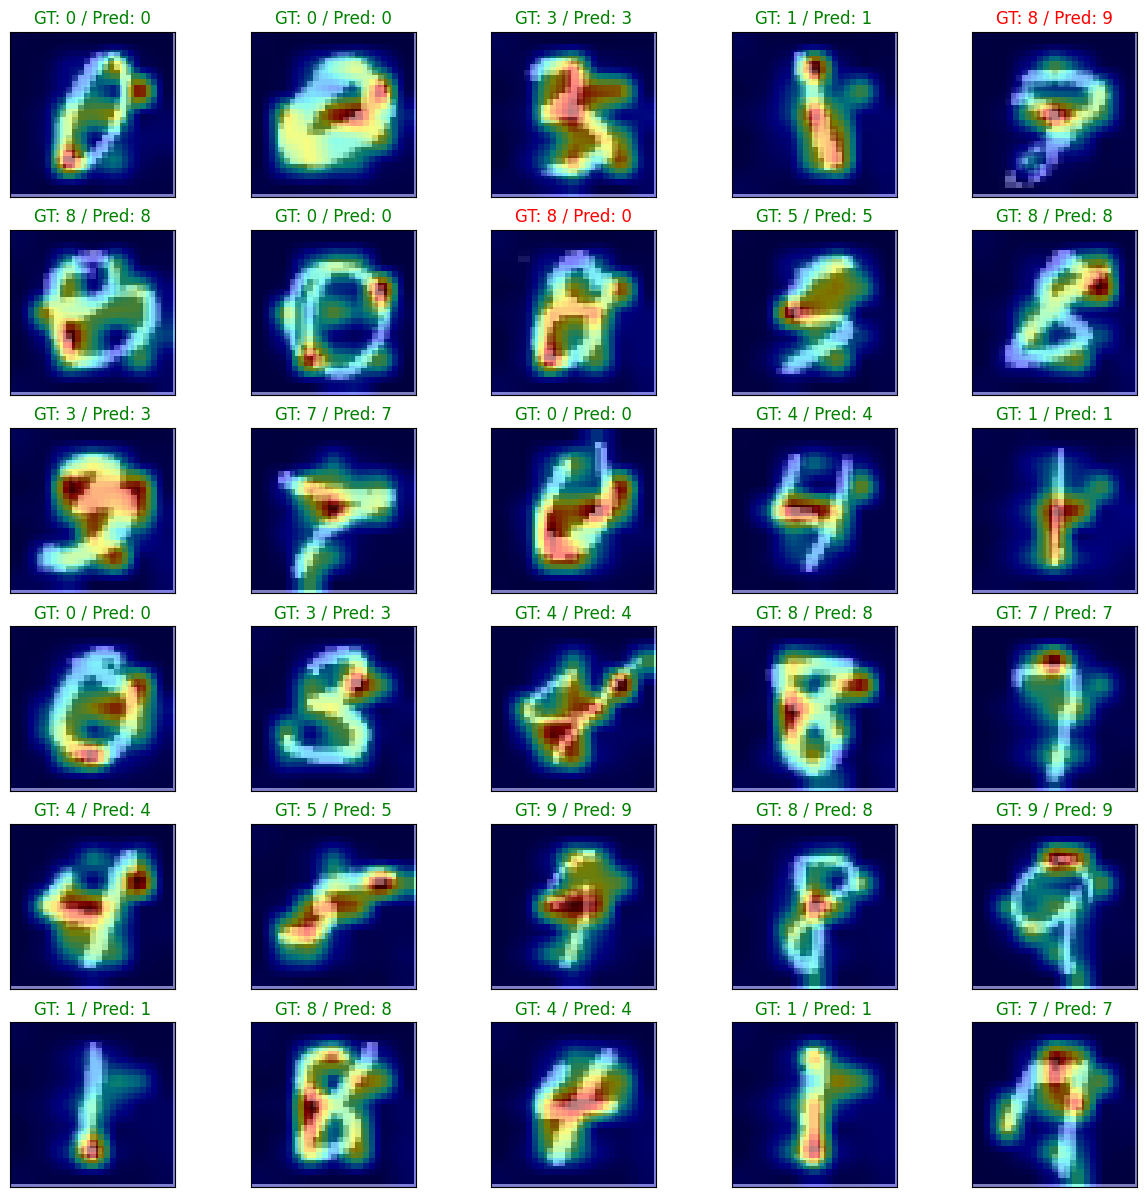

In [ ]:
visualize_attention(model, device="cuda")

# Model 2

In [ ]:
config = {
    "patch_size": 4,  # Creaing 7x7 patches (49)
    "embed_dim": 32,  # Since its, MNIST lets go with smaller dimension but note that it must be divisible by the number of heads.
    "num_hidden_layers": 2,  # Fewer layers might be sufficient for MNIST
    "num_attention_heads": 4,  # Increasing the attention head to see if that increases accuracy
    "hidden_dim": 2 * 32,  # 2 * embed_dim
    "dropout_val": 0.1,  # Some dropout to prevent overfitting on a small dataset
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 28,  # Size of MNIST images
    "num_classes": 10,  # 10 classes (digits 0-9)
    "num_channels": 1,  # Grayscale images only have 1 channel
    "qkv_bias": True,
    "use_faster_attention": True,  # Depending on whether this is supported or beneficial for your model size
}

model = vit.ViTForClassification(config)

count_parameters(model)



+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|                 embedding.cls_token                 |     32     |
|            embedding.position_embeddings            |    1600    |
|     embedding.patch_embeddings.projection.weight    |    512     |
|      embedding.patch_embeddings.projection.bias     |     32     |
|   encoder.blocks.0.attention.heads.0.query.weight   |    256     |
|    encoder.blocks.0.attention.heads.0.query.bias    |     8      |
|    encoder.blocks.0.attention.heads.0.key.weight    |    256     |
|     encoder.blocks.0.attention.heads.0.key.bias     |     8      |
|   encoder.blocks.0.attention.heads.0.value.weight   |    256     |
|    encoder.blocks.0.attention.heads.0.value.bias    |     8      |
|   encoder.blocks.0.attention.heads.1.query.weight   |    256     |
|    encoder.blocks.0.attention.he

19594

In [ ]:
# Configuration parameters
exp_name = "ViT_MNIST2"
batch_size = 64
epochs = 20
lr = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_every_n_epochs = 5
trainloader, testloader, _ = prepare_data(batch_size)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)

Epoch: 1, Train loss: 1.0247, Test loss: 0.3905, Accuracy: 0.8773
Epoch: 2, Train loss: 0.4641, Test loss: 0.3450, Accuracy: 0.8905
Epoch: 3, Train loss: 0.3873, Test loss: 0.3051, Accuracy: 0.9069
Epoch: 4, Train loss: 0.3439, Test loss: 0.2069, Accuracy: 0.9341
Epoch: 5, Train loss: 0.3135, Test loss: 0.1977, Accuracy: 0.9390
	Saving checkpoint at epoch 5
Epoch: 6, Train loss: 0.2904, Test loss: 0.2182, Accuracy: 0.9321
Epoch: 7, Train loss: 0.2752, Test loss: 0.2122, Accuracy: 0.9386
Epoch: 8, Train loss: 0.2678, Test loss: 0.1627, Accuracy: 0.9493
Epoch: 9, Train loss: 0.2586, Test loss: 0.2011, Accuracy: 0.9359
Epoch: 10, Train loss: 0.2471, Test loss: 0.1849, Accuracy: 0.9410
	Saving checkpoint at epoch 10
Epoch: 11, Train loss: 0.2422, Test loss: 0.1612, Accuracy: 0.9517
Epoch: 12, Train loss: 0.2420, Test loss: 0.1294, Accuracy: 0.9565
Epoch: 13, Train loss: 0.2291, Test loss: 0.1301, Accuracy: 0.9597
Epoch: 14, Train loss: 0.2276, Test loss: 0.1496, Accuracy: 0.9536
Epoch: 15,

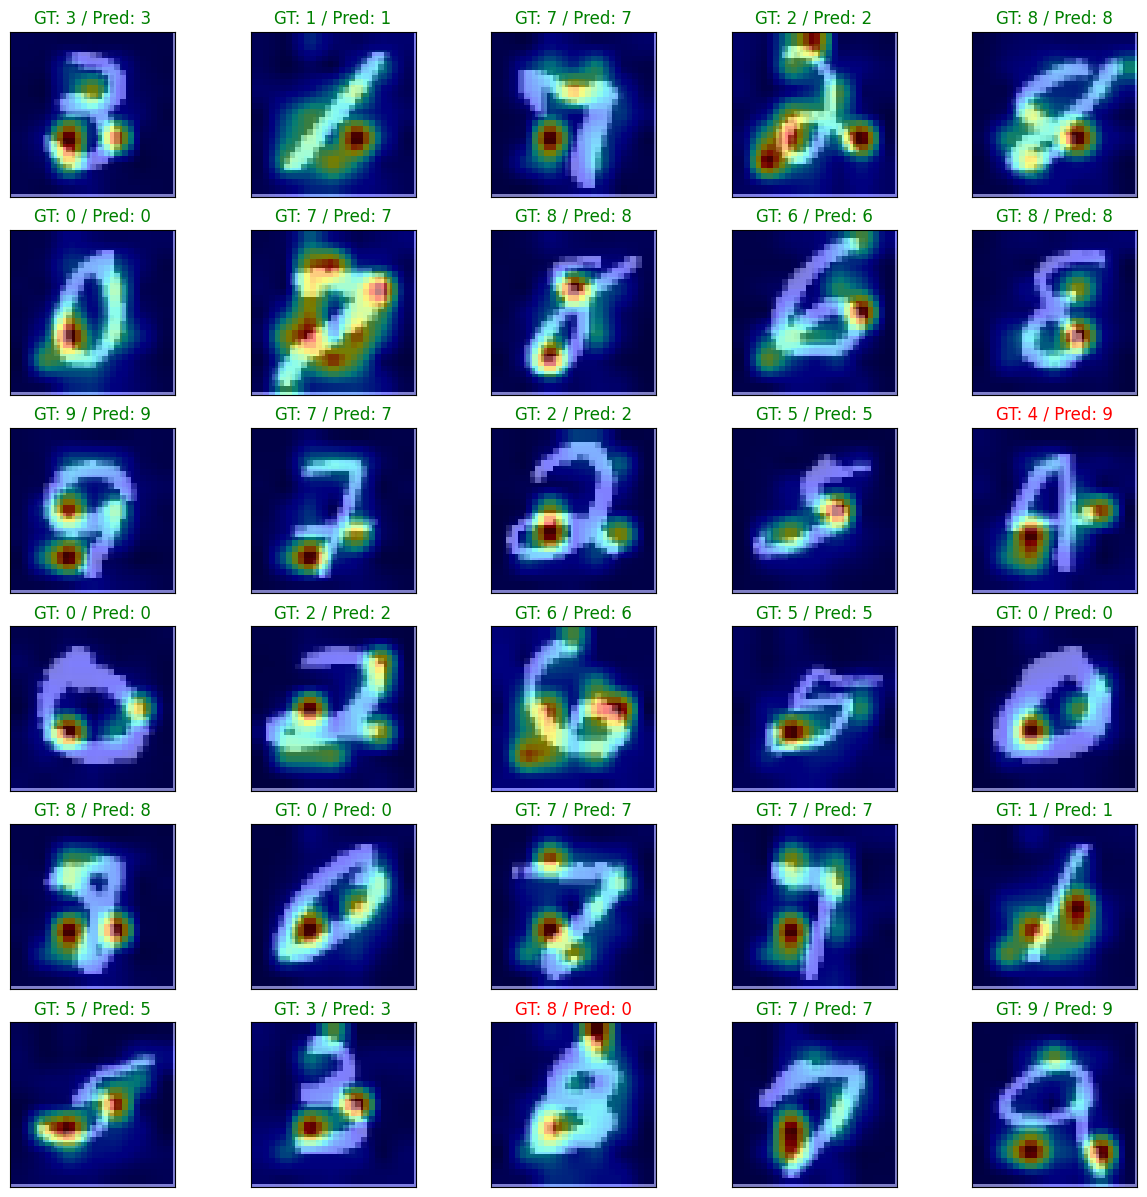

In [ ]:
visualize_attention(model, device="cuda")

In [ ]:
config = {
    "patch_size": 4,  # Creaing 7x7 patches (49)
    "embed_dim": 16,  # Since its, MNIST lets go with smaller dimension but note that it must be divisible by the number of heads.
    "num_hidden_layers": 2,  # Fewer layers might be sufficient for MNIST
    "num_attention_heads": 4,  # Increasing the attention head to see if that increases accuracy
    "hidden_dim": 2 * 16,  # 2 * embed_dim
    "dropout_val": 0.1,  # Some dropout to prevent overfitting on a small dataset
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 28,  # Size of MNIST images
    "num_classes": 10,  # 10 classes (digits 0-9)
    "num_channels": 1,  # Grayscale images only have 1 channel
    "qkv_bias": True,
    "use_faster_attention": True,  # Depending on whether this is supported or beneficial for your model size
}

model = vit.ViTForClassification(config)

count_parameters(model)

+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|                 embedding.cls_token                 |     16     |
|            embedding.position_embeddings            |    800     |
|     embedding.patch_embeddings.projection.weight    |    256     |
|      embedding.patch_embeddings.projection.bias     |     16     |
|   encoder.blocks.0.attention.heads.0.query.weight   |     64     |
|    encoder.blocks.0.attention.heads.0.query.bias    |     4      |
|    encoder.blocks.0.attention.heads.0.key.weight    |     64     |
|     encoder.blocks.0.attention.heads.0.key.bias     |     4      |
|   encoder.blocks.0.attention.heads.0.value.weight   |     64     |
|    encoder.blocks.0.attention.heads.0.value.bias    |     4      |
|   encoder.blocks.0.attention.heads.1.query.weight   |     64     |
|    encoder.blocks.0.attention.he

5706

In [ ]:
# Configuration parameters
exp_name = "ViT_MNIST3"
batch_size = 64
epochs = 20
lr = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_every_n_epochs = 5
trainloader, testloader, _ = prepare_data(batch_size)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.1795, Test loss: 0.3955, Accuracy: 0.8686
Epoch: 2, Train loss: 0.5101, Test loss: 0.2895, Accuracy: 0.9078
Epoch: 3, Train loss: 0.4113, Test loss: 0.3026, Accuracy: 0.9022
Epoch: 4, Train loss: 0.3774, Test loss: 0.1998, Accuracy: 0.9395
Epoch: 5, Train loss: 0.3585, Test loss: 0.2125, Accuracy: 0.9324
	Saving checkpoint at epoch 5
Epoch: 6, Train loss: 0.3478, Test loss: 0.2401, Accuracy: 0.9231
Epoch: 7, Train loss: 0.3351, Test loss: 0.2188, Accuracy: 0.9296
Epoch: 8, Train loss: 0.3268, Test loss: 0.2255, Accuracy: 0.9293
Epoch: 9, Train loss: 0.3178, Test loss: 0.2006, Accuracy: 0.9377
Epoch: 10, Train loss: 0.3176, Test loss: 0.2008, Accuracy: 0.9340
	Saving checkpoint at epoch 10
Epoch: 11, Train loss: 0.3103, Test loss: 0.1875, Accuracy: 0.9438
Epoch: 12, Train loss: 0.3025, Test loss: 0.1932, Accuracy: 0.9378
Epoch: 13, Train loss: 0.3022, Test loss: 0.2012, Accuracy: 0.9348
Epoch: 14, Train loss: 0.2977, Test loss: 0.1877, Accuracy: 0.9417
Epoch: 15,

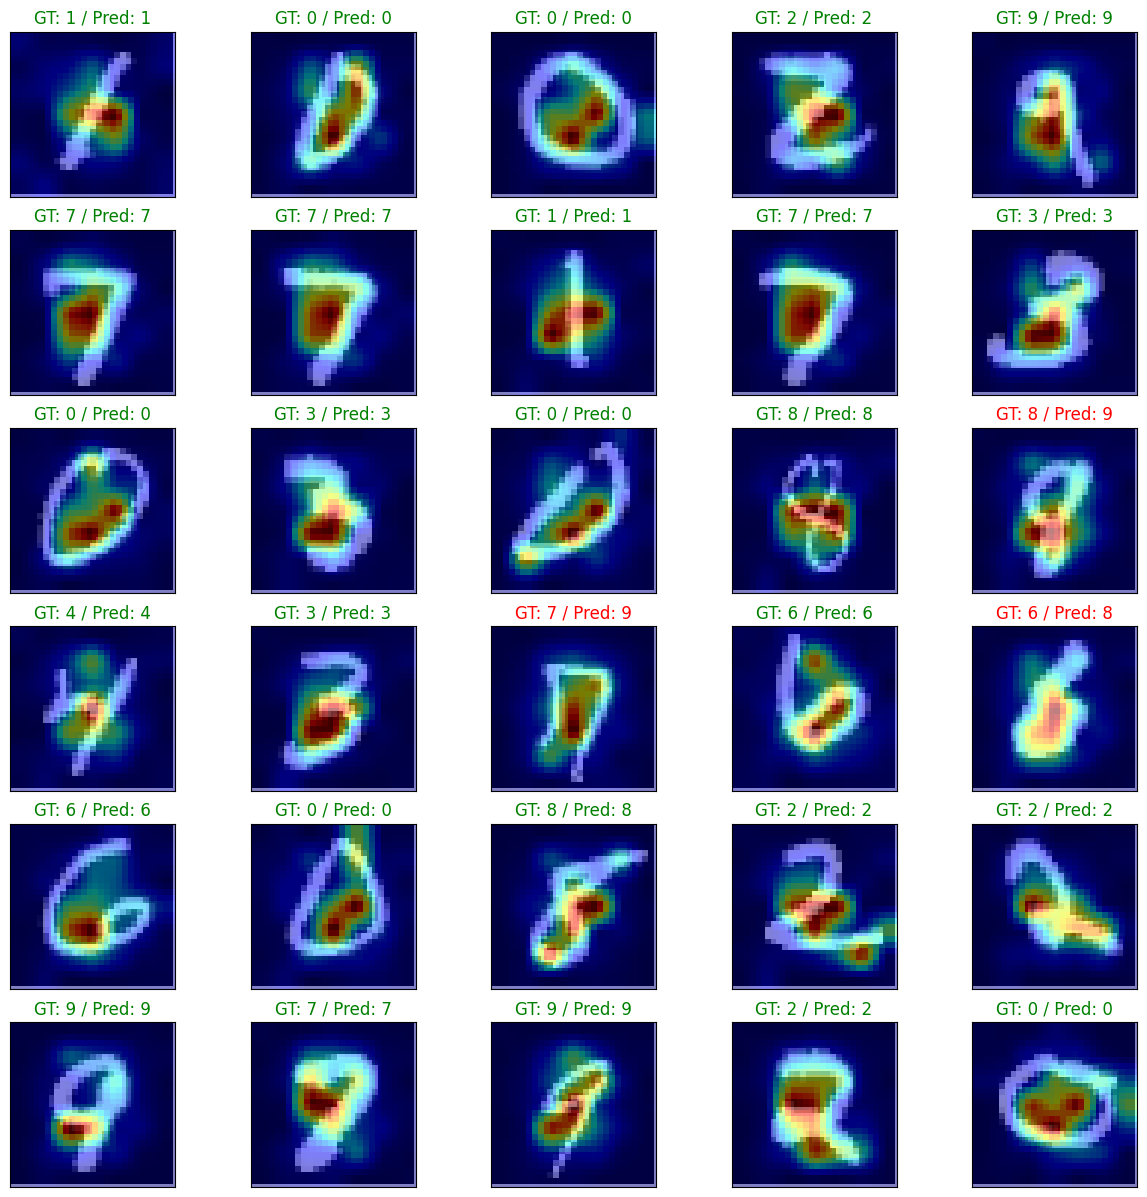

In [ ]:
visualize_attention(model, device="cuda")

In [ ]:
config = {
    "patch_size": 4,  # Creaing 7x7 patches (49)
    "embed_dim": 8,  # Since its, MNIST lets go with smaller dimension but note that it must be divisible by the number of heads.
    "num_hidden_layers": 2,  # Fewer layers might be sufficient for MNIST
    "num_attention_heads": 4,  # Increasing the attention head to see if that increases accuracy
    "hidden_dim": 2 * 8,  # 2 * embed_dim
    "dropout_val": 0.1,  # Some dropout to prevent overfitting on a small dataset
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 28,  # Size of MNIST images
    "num_classes": 10,  # 10 classes (digits 0-9)
    "num_channels": 1,  # Grayscale images only have 1 channel
    "qkv_bias": True,
    "use_faster_attention": True,  # Depending on whether this is supported or beneficial for your model size
}

model = vit.ViTForClassification(config)

count_parameters(model)

+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|                 embedding.cls_token                 |     8      |
|            embedding.position_embeddings            |    400     |
|     embedding.patch_embeddings.projection.weight    |    128     |
|      embedding.patch_embeddings.projection.bias     |     8      |
|   encoder.blocks.0.attention.heads.0.query.weight   |     16     |
|    encoder.blocks.0.attention.heads.0.query.bias    |     2      |
|    encoder.blocks.0.attention.heads.0.key.weight    |     16     |
|     encoder.blocks.0.attention.heads.0.key.bias     |     2      |
|   encoder.blocks.0.attention.heads.0.value.weight   |     16     |
|    encoder.blocks.0.attention.heads.0.value.bias    |     2      |
|   encoder.blocks.0.attention.heads.1.query.weight   |     16     |
|    encoder.blocks.0.attention.he

1834

In [ ]:
# Configuration parameters
exp_name = "ViT_MNIST4"
batch_size = 64
epochs = 20
lr = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_every_n_epochs = 5
trainloader, testloader, _ = prepare_data(batch_size)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)

Epoch: 1, Train loss: 1.5079, Test loss: 0.9514, Accuracy: 0.6750
Epoch: 2, Train loss: 0.9384, Test loss: 0.5809, Accuracy: 0.8035
Epoch: 3, Train loss: 0.7339, Test loss: 0.4823, Accuracy: 0.8397
Epoch: 4, Train loss: 0.6519, Test loss: 0.3685, Accuracy: 0.8857
Epoch: 5, Train loss: 0.6028, Test loss: 0.3666, Accuracy: 0.8843
	Saving checkpoint at epoch 5
Epoch: 6, Train loss: 0.5878, Test loss: 0.3471, Accuracy: 0.8873
Epoch: 7, Train loss: 0.5736, Test loss: 0.3521, Accuracy: 0.8876
Epoch: 8, Train loss: 0.5640, Test loss: 0.3324, Accuracy: 0.8919
Epoch: 9, Train loss: 0.5514, Test loss: 0.3138, Accuracy: 0.9017
Epoch: 10, Train loss: 0.5438, Test loss: 0.3380, Accuracy: 0.8893
	Saving checkpoint at epoch 10
Epoch: 11, Train loss: 0.5385, Test loss: 0.3398, Accuracy: 0.8921
Epoch: 12, Train loss: 0.5294, Test loss: 0.2955, Accuracy: 0.9081
Epoch: 13, Train loss: 0.5168, Test loss: 0.3109, Accuracy: 0.9032
Epoch: 14, Train loss: 0.5201, Test loss: 0.2900, Accuracy: 0.9097
Epoch: 15,

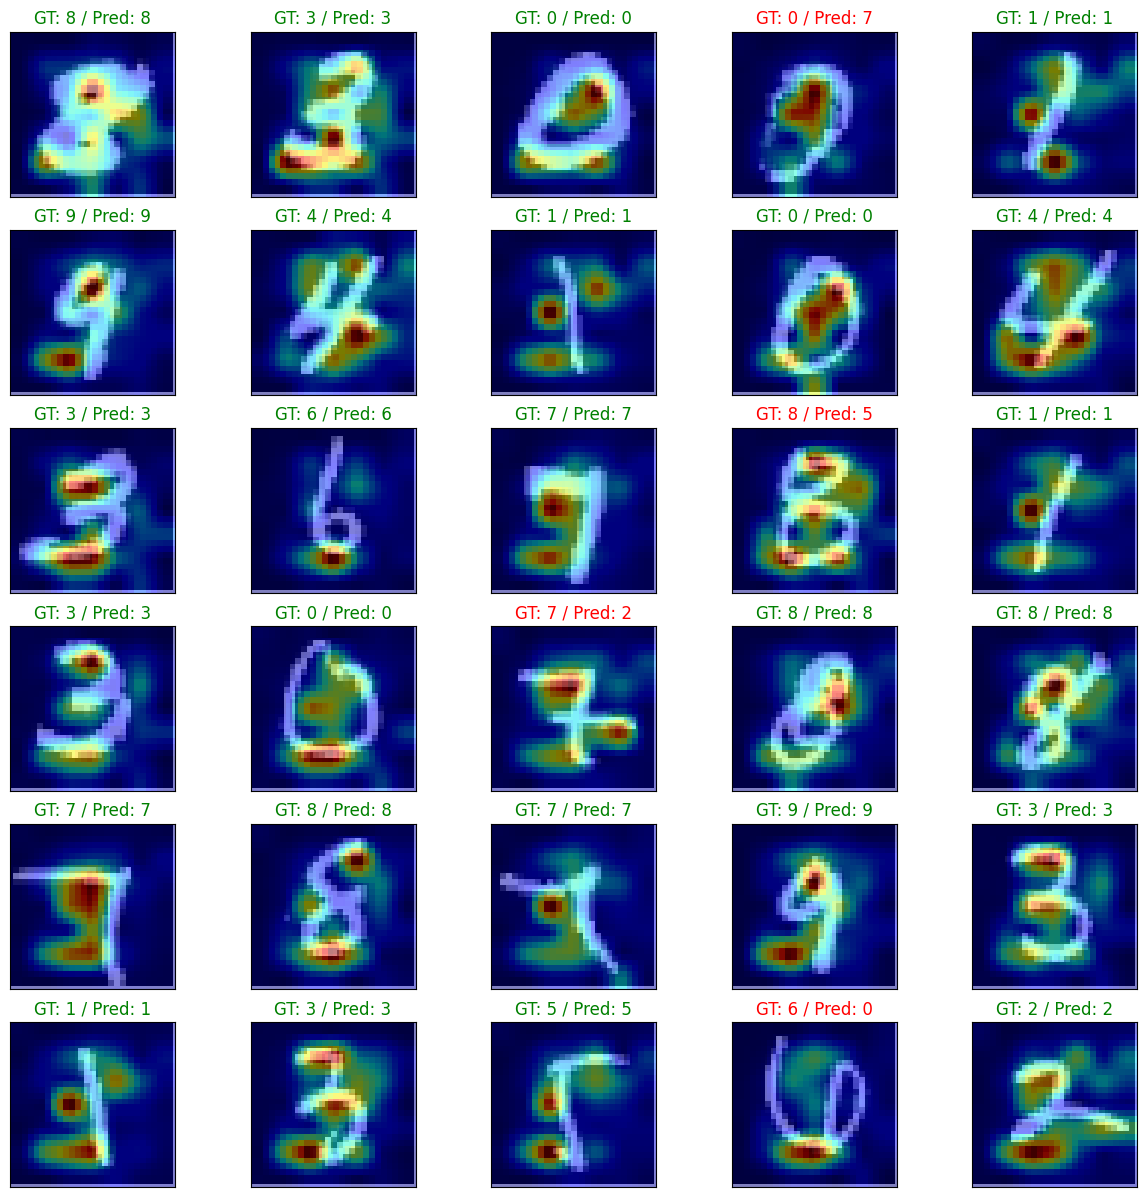

In [ ]:
visualize_attention(model, device="cuda")